# Environment Setup

In [1]:
import gpytoolbox as gpy
import numpy as np
import matplotlib.pyplot as plt
import utils

# Sampling Surfaces from Point Clouds

## Problem statement

Broadly, the problem we are going to try to solve together is the following:

*Given a set of points $\mathcal{X}=\{x_i\}_{i=1}^n$ on a surface and some "prior" on the space of possible surfaces, how can we define a distribution $\mathcal{P}$ over the space of possible surfaces*
$$\mathcal{S} = \{S\subset \mathbb{R}^d\,:\, \text{dim}(S)=d-1\,,\,x_i\in S\}$$
*that encodes such prior and such that we can*  
1. *compute the probability density of a given surface $S\in\mathcal{S}$, which we denote $p(S)$.*  
2. *generate random surfaces from $\mathcal{S}$ according to $\mathcal{P}$, which we denote $S_1,\dots,S_k\sim\mathcal{P}$*

## Representing point clouds

In our computer, we will store point clouds as $n\times d$ matrices, with each row corresponding to one point. In two dimensions; for example, this is a valid point cloud:

In [2]:
X = np.array([[0,0],[1,0],[1,1],[0,1]])

The best way to plot point clouds is to use matplotlib's `scatter` function

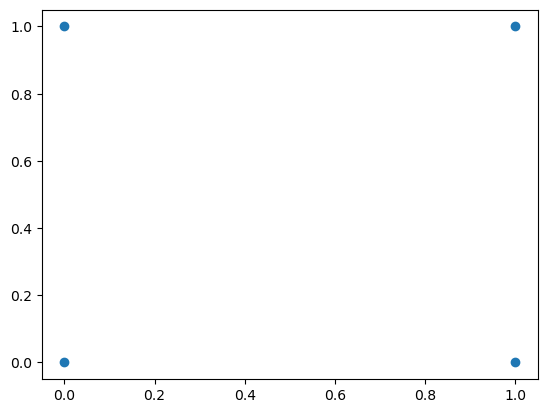

In [3]:
plt.scatter(X[:,0],X[:,1])

During our project, we will want to easily generate different point clouds to test our algorithms on. In practice, a very useful way of generating point clouds is by first turning any image into a polyline, and then sampling the polyline. This can be done with our library `gpytoolbox` in two steps, which are detailed [here](https://www.silviasellan.com/gpytoolbox-2d-prototyping.html) and [here](https://www.silviasellan.com/gpytoolbox-2d-prototyping-2.html) but we can summarize below:

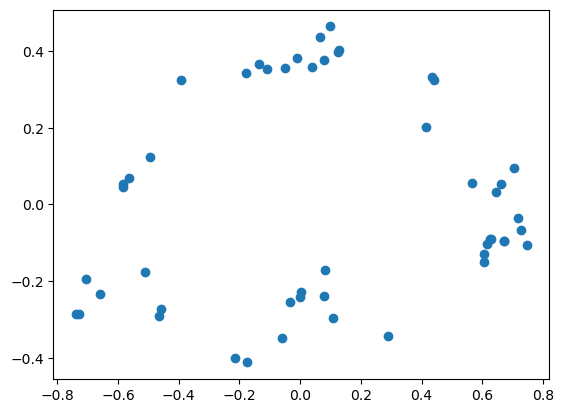

In [4]:
# Begin by loading the image into a polyline
poly = gpy.png2poly("data/switzerland.png")
vertices = poly[0]
vertices = 1.5*gpy.normalize_points(vertices)
edges = gpy.edge_indices(vertices.shape[0])

# Now sample from it to generate points
X = gpy.random_points_on_mesh(vertices, edges, 50)

# plot the points
plt.scatter(X[:,0],X[:,1])

## Representing surfaces: an algorithmic choice

Like we saw in the tutorial week, there are many ways of representing surfaces. In our project, we're going to have to compare surfaces to each other with different sizes, topologies, etc. so it will be easier to use an implicit representation; i.e., for us, a surface will be the same as a function $f:\mathbb{R}^d\rightarrow\mathbb{R}$ and we will identify surfaces $S$ with functions $f$ such that the zero levelset matches, $S=f^{-1}(0)$.

Of course, this only turns our problem statement into another: *how does one go from a point cloud $X$ to a distribution of functions $f$ that are zero at all the points in $X$?*. One way of answering it is by using a *Gaussian Process* ([this book](http://robotics.caltech.edu/wiki/images/d/d1/RasumussenWilliamsBook.pdf) is a great resource on Gaussian Processes). In other words, this means interpreting the points in the point cloud as samples from a statistical distribution $\{(x_i,f_i=0)\}$ and asking, for any $x\in\mathbb{R}^d$, for the *conditional distribution*
$$p(f(x)\,|\,x_0,f_0=0,\dots,x_n,f_n=0)$$
which will be a Gaussian distribution with a mean $m(x)$ and variance $\sigma^2(x)$.

We implemented our gaussian process class and kernel functions available in this repository.

### Kernel Functions

* [Square Exponential Kernel](https://en.wikipedia.org/wiki/Covariance_function)
* [Thin Plate Spline Kernel](http://gpss.cc/gpip/abstract/owilliams.pdf)

### Gaussian Process Class

* fit: Train your GP (Precompute gaussian process)
* predict: generate predictions for X_test values
* fit_and_predict: fit with X_train and y_train values, then predict for X_test values

## Initial Step

### Squared Exponential Kernel

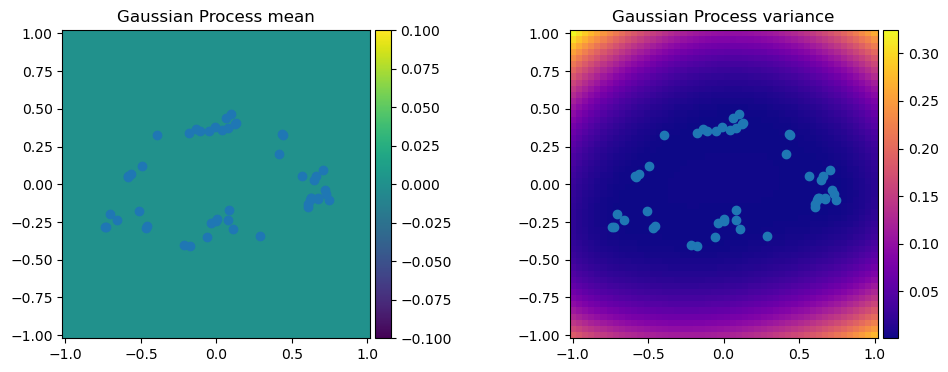

In [5]:
gp = utils.GaussianProcess()
xs = np.linspace(-1,1,50)
ys = np.linspace(-1,1,50)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
Vs = np.vstack((Xs,Ys)).T
mu, Q = gp.fit_and_predict(X, Vs)
utils.gp_mean_variance_plot(xs,ys,mu,Q,(50,50), X)

Oh no! What happened? The variance looks reasonable but the mean in our GP has returned all zeros!

If you think about it for a bit, this makes sense: all our observations are zero, why would the GP conclude anything else than our function being zero everywhere? To avoid this, a classic trick is to "hallucinate" a few positive and negative samples; for example, we may place a negative sample at the origin and positive samples at the corners of the square:

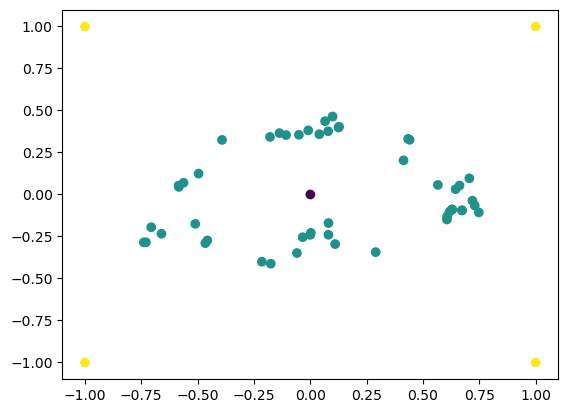

In [6]:
# Now our samples will concatenate the point cloud and a few hallucinated samples
positive_fake_samples = np.array([[1,1],[-1,1],[1,-1],[-1,-1]])
negative_fake_samples = np.array([[0.0,0.0]])
fake_samples = np.vstack((positive_fake_samples,negative_fake_samples))
fake_sample_values = np.array([1,1,1,1,-1])

# Now let's define our "training data" that concatenates X and the fake samples
training_data = np.vstack((X,fake_samples))
training_data_values = np.hstack((np.zeros(X.shape[0]),fake_sample_values))

# Let's plot this:
plt.scatter(training_data[:,0],training_data[:,1],c=training_data_values)

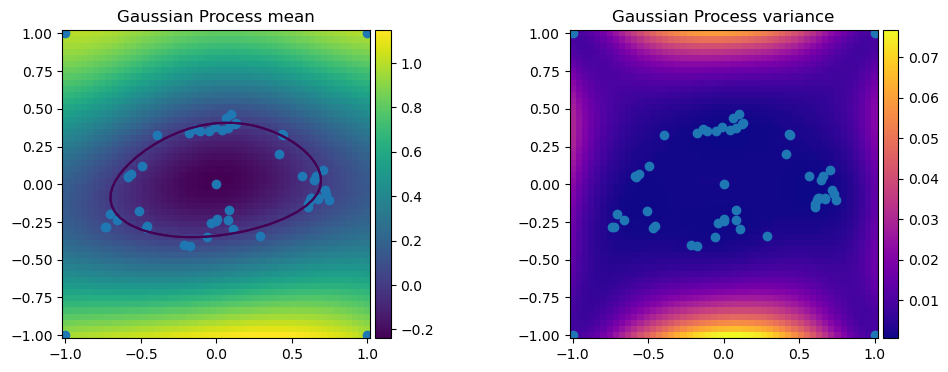

In [7]:
mu, Q = gp.fit_and_predict(training_data, Vs, y_train=training_data_values)
utils.gp_mean_variance_plot(xs,ys,mu,Q,(50,50), training_data, True)

We have gotten a function that has zero value at every point in the cloud. Is this a good surface though? How can we do better?

### Thin Plate Spline Kernel

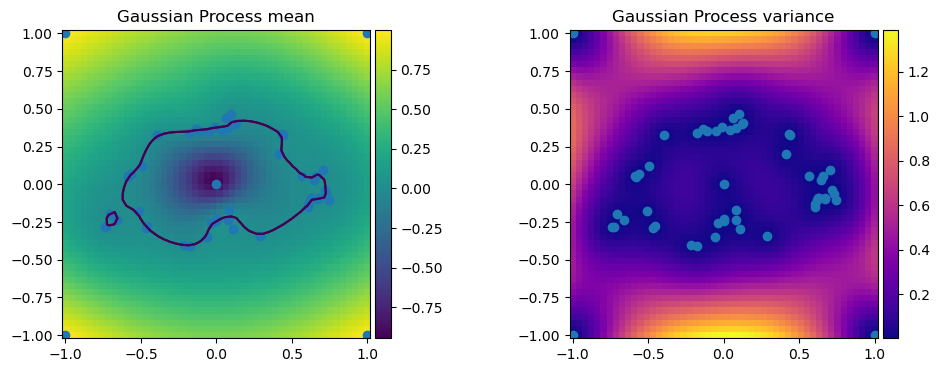

In [8]:
gp = utils.GaussianProcess(kernel=utils.thin_plate_spline_kernel)
xs = np.linspace(-1,1,50)
ys = np.linspace(-1,1,50)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
Vs = np.vstack((Xs,Ys)).T

# Now our samples will concatenate the point cloud and a few hallucinated samples
positive_fake_samples = np.array([[1,1],[-1,1],[1,-1],[-1,-1]])
negative_fake_samples = np.array([[0.0,0.0]])
fake_samples = np.vstack((positive_fake_samples,negative_fake_samples))
fake_sample_values = np.array([1,1,1,1,-1])
# Now let's define our "training data" that concatenates X and the fake samples
training_data = np.vstack((X,fake_samples))
training_data_values = np.hstack((np.zeros(X.shape[0]),fake_sample_values))

mu, Q = gp.fit_and_predict(training_data, Vs, y_train=training_data_values)
utils.gp_mean_variance_plot(xs,ys,mu,Q,(50,50), training_data, True)

The thin plate spline kernel improves our results. But we can still do better, without "hallucinating" points in our set. Our next steps is to incorporate normal directions into the Gaussian Process, as described [here](https://www.honda-ri.de/pubs/pdf/1717.pdf).

## Gaussian Process with Normal Directions

### Squared Exponential Kernel w/ Derivatives

Starting training...
Finished training in 1.6242883205413818 seconds
Starting predictions...
Computed cross-covariance matrix in 1.0937275886535645 seconds
Computed mean in 0.0006053447723388672 seconds
Computed test data covariance matrix in 1.7362689971923828 seconds
Computed variance in 0.3359534740447998 seconds
Total time: 3.166015386581421 seconds


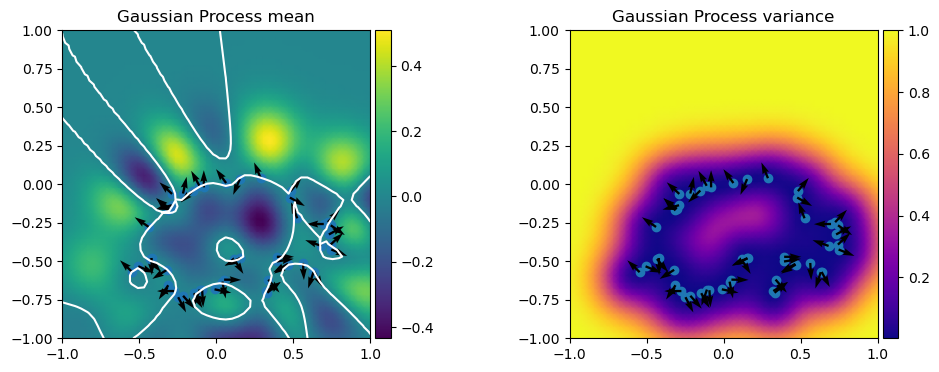

In [9]:
poly = gpy.png2poly("data/switzerland.png")[0]
poly = poly - np.min(poly)
poly = poly/np.max(poly)
poly = 0.5*poly + 0.25
poly = 3*poly - 1.5
num_samples = 50

EC = gpy.edge_indices(poly.shape[0],closed=False)
X,I,_ = gpy.random_points_on_mesh(poly, EC, num_samples, return_indices=True,rng=np.random.default_rng(0))
vecs = poly[EC[:,0],:] - poly[EC[:,1],:]
vecs /= np.linalg.norm(vecs, axis=1)[:,None]
J = np.array([[0., -1.], [1., 0.]])
N = vecs @ J.T
N = N[I,:]

xs = np.linspace(-1,1,50)
ys = np.linspace(-1,1,50)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
Vs = np.vstack((Xs,Ys)).T

gp = utils.NormalsGaussianProcess()
mu, Q = gp.fit_and_predict(X, Vs, N)

utils.ngp_mean_variance_plot(xs,ys,mu[:2500],Q[:2500,:2500],(50,50), X, N, True)

### Thin Plate Spline Kernel w/Derivatives

Starting training...
Finished training in 0.012047767639160156 seconds
Starting predictions...
Computed cross-covariance matrix in 0.1535353660583496 seconds
Computed mean in 0.0009834766387939453 seconds
Computed test data covariance matrix in 1.830108642578125 seconds
Computed variance in 0.623784065246582 seconds
Total time: 2.6075048446655273 seconds


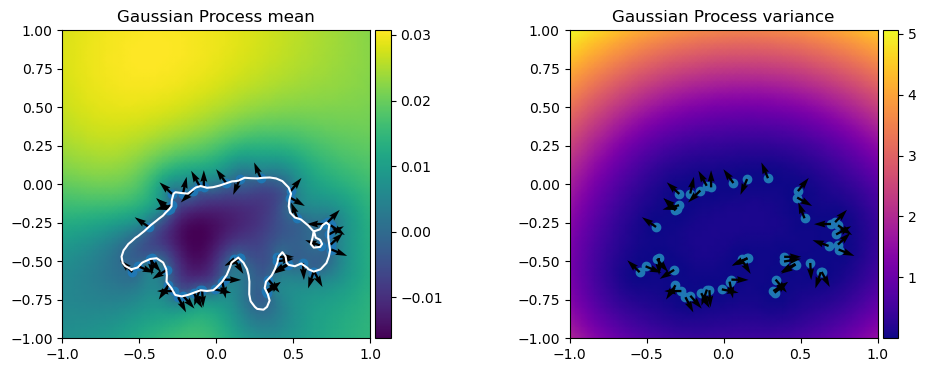

In [10]:
poly = gpy.png2poly("data/switzerland.png")[0]
poly = poly - np.min(poly)
poly = poly/np.max(poly)
poly = 0.5*poly + 0.25
poly = 3*poly - 1.5
num_samples = 50

EC = gpy.edge_indices(poly.shape[0],closed=False)
X,I,_ = gpy.random_points_on_mesh(poly, EC, num_samples, return_indices=True,rng=np.random.default_rng(0))
vecs = poly[EC[:,0],:] - poly[EC[:,1],:]
vecs /= np.linalg.norm(vecs, axis=1)[:,None]
J = np.array([[0., -1.], [1., 0.]])
N = vecs @ J.T
N = N[I,:]

xs = np.linspace(-1,1,50)
ys = np.linspace(-1,1,50)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
Vs = np.vstack((Xs,Ys)).T

gp = utils.NormalsGaussianProcess(method="inv",kernel=utils.apply_thin_plate_spline_covariance, R_val=True, R=2*2**0.5)

mu, Q = gp.fit_and_predict(X, Vs, N, sigma_noise=0.001)
utils.ngp_mean_variance_plot(xs,ys,mu[:2500],Q[:2500,:2500],(50,50), X, N, True)

That looks much better! Now, let's sample some surfaces!

## Sampling

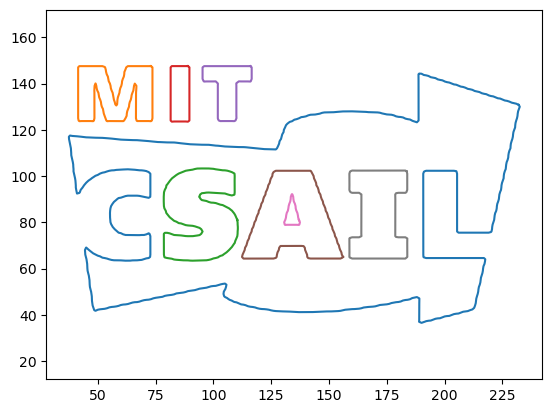

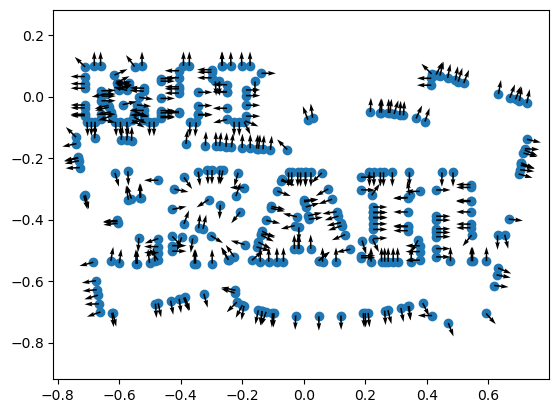

In [29]:
X,N = utils.data_from_img("data/mit_csail_logo.png", num_samples=(150,60,30,15,25,40,8,40),random_seed=2) #368 samples

plt.scatter(X[:,0],X[:,1])
plt.quiver(X[:,0],X[:,1],N[:,0],N[:,1])
plt.axis("equal")
plt.show()

Starting training...
Finished training in 0.18012619018554688 seconds
Starting predictions...
Computed cross-covariance matrix in 0.28737473487854004 seconds
Computed mean in 0.002969980239868164 seconds
Computed test data covariance matrix in 1.6131649017333984 seconds
Computed variance in 0.9122445583343506 seconds
Total time: 2.8128528594970703 seconds


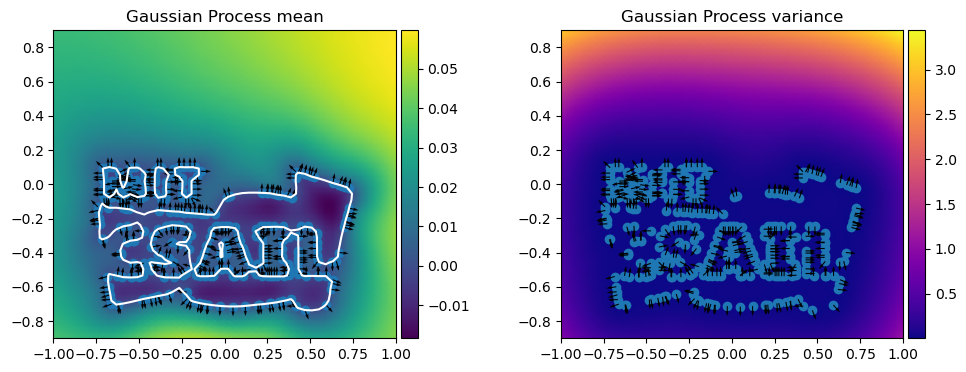

In [30]:
xs = np.linspace(-1,1,50)
ys = np.linspace(-0.9,0.9,50)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
Vs = np.vstack((Xs,Ys)).T

gp = utils.NormalsGaussianProcess(method="inv",kernel=utils.apply_thin_plate_spline_covariance, R_val=True, R=2*2**0.5)

mu, Q = gp.fit_and_predict(X, Vs, N, sigma_noise=0.001)
utils.ngp_mean_variance_plot(xs,ys,mu[:2500],Q[:2500,:2500],(50,50), X, N, True)

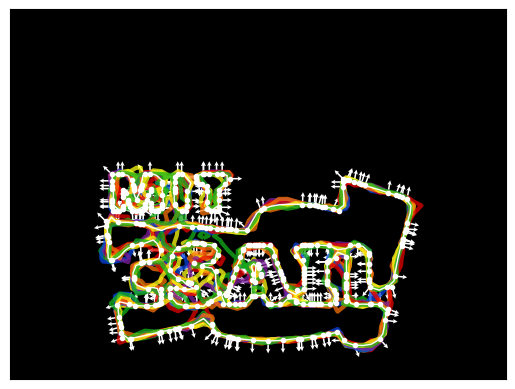

In [31]:
colors = ['xkcd:red','xkcd:orange','xkcd:yellow','xkcd:green','xkcd:blue','xkcd:purple']
samples = []
for i in range(10):
  Q[Q<0] = 0
  samples.append(utils.sample_surface(xs, ys, mu[:50**2], 5e-5*Q[:50**2,:50**2]**0.5, (50,50), X, plot=False, line_color=colors[i%6]))


for i in range(10):
  plt.contour(xs,ys,samples[i].reshape((50,50)),levels=[0], colors=colors[i%len(colors)],linewidths=3, alpha=0.75)
plt.axis('equal')
ax = plt.gca()
ax.set_facecolor('k')
plt.plot(X[:,0],X[:,1], color='w',marker='o',linestyle='',ms=3)
plt.contour(xs,ys,mu[:50**2].reshape((50,50)),levels=[0], colors='white',linewidths=1)

plt.quiver(X[:,0],X[:,1],N[:,0],N[:,1],scale=40,headlength=3,headaxislength=2.5,color='w')
ax.set_yticks([])
ax.set_xticks([])
plt.savefig("data/MIT_CSAIL_random_sample.png", format="png", dpi=1200)
plt.show()

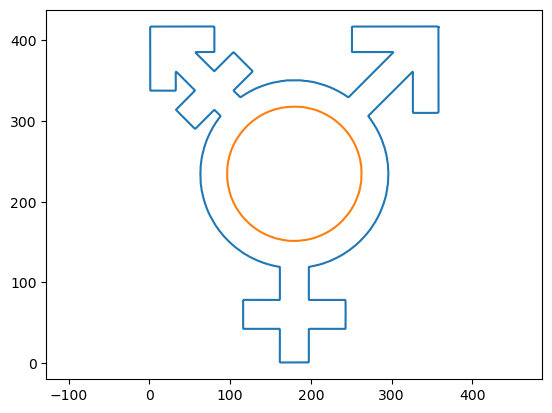

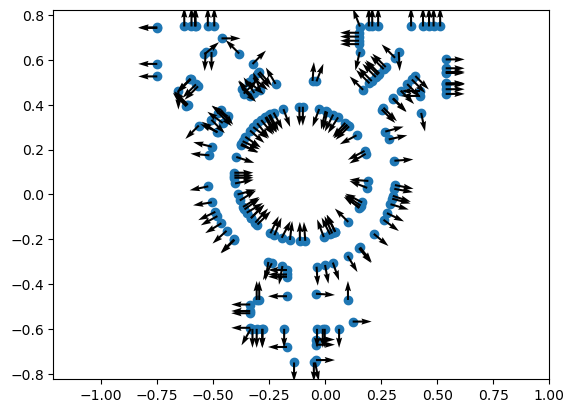

Starting training...
Finished training in 1.6656451225280762 seconds
Starting predictions...
Computed cross-covariance matrix in 1.0180444717407227 seconds
Computed mean in 0.002296924591064453 seconds
Computed test data covariance matrix in 1.6638553142547607 seconds
Computed variance in 0.5426623821258545 seconds
Total time: 3.2246389389038086 seconds


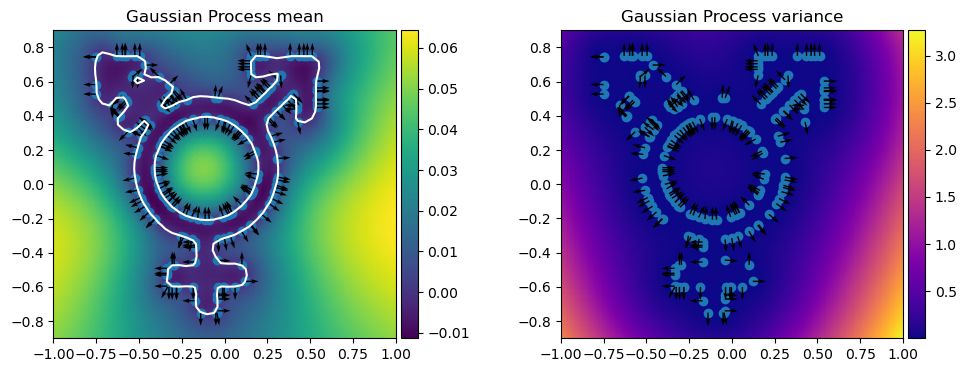

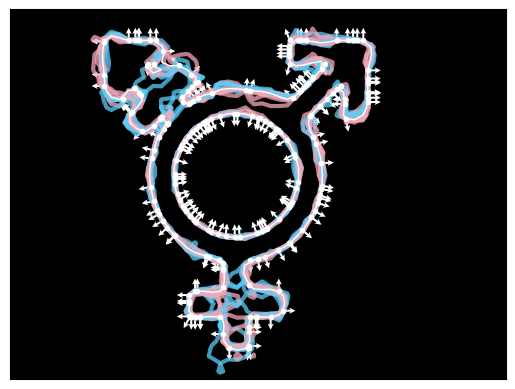

In [28]:
X,N = utils.data_from_img("data/trans_symbol.png", num_samples=(150,60,30,15,25,40,8,40),random_seed=2) #368 samples

plt.scatter(X[:,0],X[:,1])
plt.quiver(X[:,0],X[:,1],N[:,0],N[:,1])
plt.axis("equal")
plt.show()

xs = np.linspace(-1,1,50)
ys = np.linspace(-0.9,0.9,50)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
Vs = np.vstack((Xs,Ys)).T

gp = utils.NormalsGaussianProcess(method="inv",kernel=utils.apply_thin_plate_spline_covariance, R_val=True, R=2*2**0.5)

mu, Q = gp.fit_and_predict(X, Vs, N, sigma_noise=0.001)
utils.ngp_mean_variance_plot(xs,ys,mu[:2500],Q[:2500,:2500],(50,50), X, N, True)

colors = ['xkcd:red','xkcd:orange','xkcd:yellow','xkcd:green','xkcd:blue','xkcd:purple']
samples = []
for i in range(10):
  Q[Q<0] = 0
  samples.append(utils.sample_surface(xs, ys, mu[:50**2], 5e-5*Q[:50**2,:50**2]**0.5, (50,50), X, plot=False, line_color=colors[i%6]))

colors = ['#5bcefa','#f5a9b8']

for i in range(10):
  plt.contour(xs,ys,samples[i].reshape((50,50)),levels=[0], colors=colors[i%len(colors)],linewidths=3, alpha=0.75)
plt.axis("equal")
ax = plt.gca()
ax.set_facecolor('k')
plt.plot(X[:,0],X[:,1], color='w',marker='o',linestyle='',ms=3)
plt.contour(xs,ys,mu[:50**2].reshape((50,50)),levels=[0], colors='white',linewidths=1)

plt.quiver(X[:,0],X[:,1],N[:,0],N[:,1],scale=40,headlength=3,headaxislength=2.5,color='w')
ax.set_yticks([])
ax.set_xticks([])
plt.savefig("data/trans_random_sample.png", format="png", dpi=1200)
plt.show()

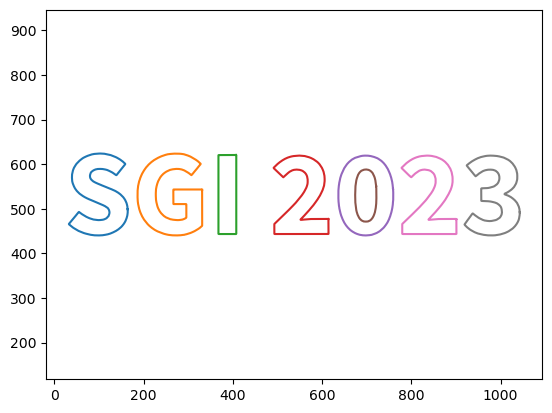

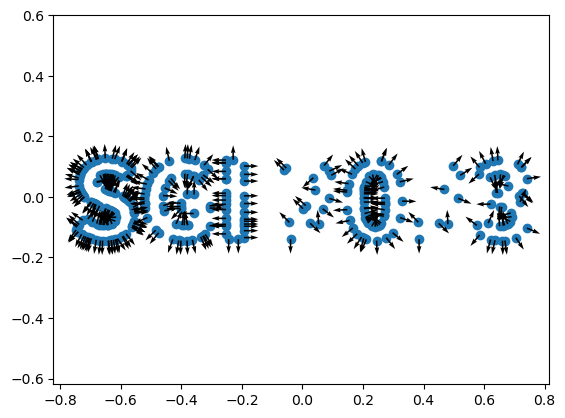

Starting training...
Finished training in 1.8213589191436768 seconds
Starting predictions...
Computed cross-covariance matrix in 1.1240513324737549 seconds
Computed mean in 0.0033636093139648438 seconds
Computed test data covariance matrix in 2.3361306190490723 seconds
Computed variance in 1.9161498546600342 seconds
Total time: 5.376398801803589 seconds


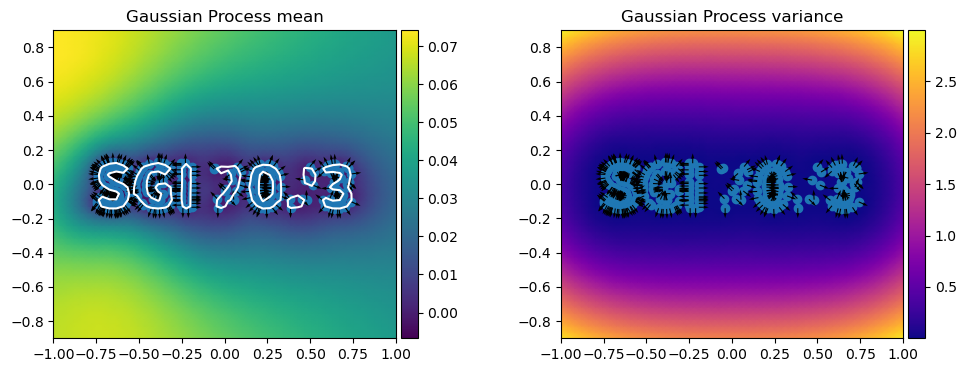

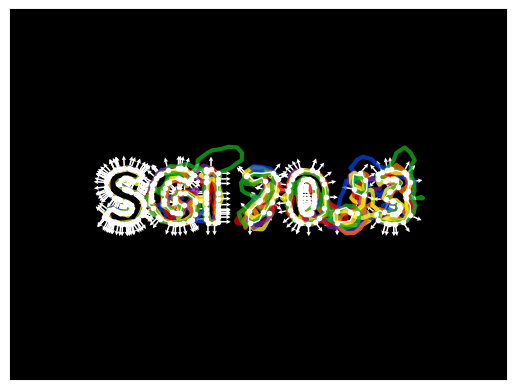

In [32]:
X,N = utils.data_from_img("data/SGI_2023.png", num_samples=(150,60,30,15,25,40,8,40),random_seed=2) #368 samples

plt.scatter(X[:,0],X[:,1])
plt.quiver(X[:,0],X[:,1],N[:,0],N[:,1])
plt.axis("equal")
plt.show()

xs = np.linspace(-1,1,50)
ys = np.linspace(-0.9,0.9,50)
Xs,Ys = np.meshgrid(xs,ys)
Xs = Xs.flatten()
Ys = Ys.flatten()
Vs = np.vstack((Xs,Ys)).T

gp = utils.NormalsGaussianProcess(method="inv",kernel=utils.apply_thin_plate_spline_covariance, R_val=True, R=2*2**0.5)

mu, Q = gp.fit_and_predict(X, Vs, N, sigma_noise=0.001)
utils.ngp_mean_variance_plot(xs,ys,mu[:2500],Q[:2500,:2500],(50,50), X, N, True)

colors = ['xkcd:red','xkcd:orange','xkcd:yellow','xkcd:green','xkcd:blue','xkcd:purple']
samples = []
for i in range(10):
  Q[Q<0] = 0
  samples.append(utils.sample_surface(xs, ys, mu[:50**2], 5e-5*Q[:50**2,:50**2]**0.5, (50,50), X, plot=False, line_color=colors[i%6]))


for i in range(10):
  plt.contour(xs,ys,samples[i].reshape((50,50)),levels=[0], colors=colors[i%len(colors)],linewidths=3, alpha=0.75)
plt.axis('equal')
ax = plt.gca()
ax.set_facecolor('k')
plt.plot(X[:,0],X[:,1], color='w',marker='o',linestyle='',ms=3)
plt.contour(xs,ys,mu[:50**2].reshape((50,50)),levels=[0], colors='white',linewidths=1)

plt.quiver(X[:,0],X[:,1],N[:,0],N[:,1],scale=40,headlength=3,headaxislength=2.5,color='w')
ax.set_yticks([])
ax.set_xticks([])
plt.savefig("data/sgi_random_sample.png", format="png", dpi=1200)
plt.show()